<a href="https://colab.research.google.com/github/namespaceStedd/atanalize/blob/main/3.2.%20Classification%20Movie%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Для управления данными
import pandas
import numpy
## Для построения графиков
import matplotlib.pyplot as plot
import seaborn
## Для статистического тестирования
import scipy
import statsmodels.formula.api as statistic_formula
import statsmodels.api as statistic_model
## Для машинного обучения
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition


## Загрузка данных

In [2]:
def optional_import(case, processed):
  if case == 1:
    file = '1-pXQLNrBueN8opV2DLScuPgc3ICyx1bXRISw_XMx4ao' if processed else '1pdvn2vfbOcFS5MOL5oezEaswwiwqKitkJ0sTLh8XTXo';
    url = 'https://docs.google.com/spreadsheets/d/' + file + '/export?format=csv';
    return pandas.read_csv(url);
  else:
    file = 'Toxicity-13F.csv' if processed else 'data.csv';
    from google.colab import drive
    drive.mount('/content/gdrive/')
    return pandas.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Toxicity/Data/' + file);


# Опционально выбираем, как хотим импортировать:
# 1 - по ссылке на Google Spreadsheets
# 0 - прямым импортом с Google Drive
# True - использовать предобработанный файл (13 показателей ;) )
# False - использовать оригинальный (1203 показателя !!!)
toxicity = optional_import(1, True);
toxicity.head()


,MDEC-23,MATS2v,ATSC8s,VE3_Dt,CrippenMR,SpMax7_Bhe,SpMin1_Bhs,C1SP2,GATS8e,GATS8s,SpMax5_Bhv,VE3_Dzi,VPC-4,Class
0,60.1757,-0.0231,-0.6667,-167.1241,0.0000,3.4009,2.3109,4,1.0229,1.0575,3.5545,-15.5940,4.1692,NonToxic
1,44.5031,-0.1236,-16.5096,-16.2080,172.2000,3.3611,2.1117,2,1.7155,1.7013,3.6066,-14.3317,2.0821,NonToxic
2,37.5488,0.0662,19.3467,-159.1796,173.4028,3.2705,2.0198,8,0.6992,0.7828,3.6441,-25.4493,2.8730,NonToxic
3,40.5929,0.0714,-9.5672,-21.4416,177.2726,3.2748,2.0191,6,0.9951,1.0298,3.6564,-19.6376,3.0444,NonToxic
4,52.7343,-0.0861,-11.8892,-2.0780,171.1315,3.4094,2.1664,2,0.7363,0.7427,3.5216,-8.2157,2.9469,NonToxic


In [3]:
'''
Определяет, является ли столбец числовым или категориальным.
:параметр
     :param dataset:dataframe - входные данные
     :param column:str - имя столбца для анализа
     :param unique_max:num — максимальное количество уникальных значений для распознавания столбца как категориального
:возвращает
     "categorical", если столбец является категориальным или "numerical" в противном случае
'''
def recognize_type(dataset, column, unique_max):
    if (dataset[column].dtype == "O") | (dataset[column].nunique() < unique_max):
        return "categorical"
    else:
        return "numerical"


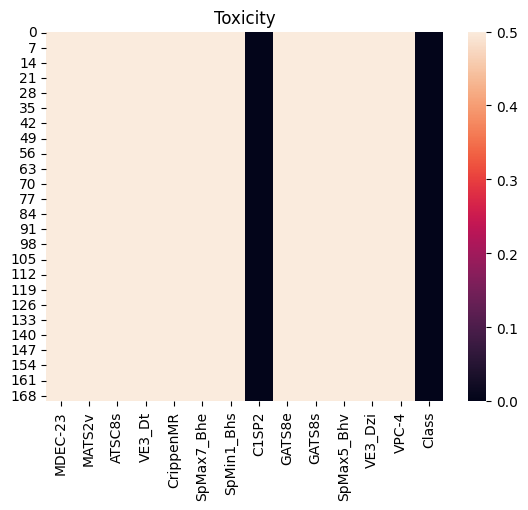

 Категориальный   Числовой   Без данных 


In [4]:
'''
формируем словарь columns_dictionary.
Ключи - название параметров
Значение - категориальный (categorical) или числовой (numerical)
'''
columns_dictionary = {column:recognize_type(toxicity, column, 10) for column in toxicity.columns}


'''
toxicity.isnull() - возвращает датасет, который похож на изначальный датасет toxicity, но в каждой ячейке вместо значений написано:
 False (если значение есть)
 True  (если в ячейке отсутствует значение)
'''
heatmap = toxicity.isnull();


'''
А дальше проходим по столбцам, и меняем значения:
  если столбец числовой:
    пишем 0.5, если значение False (то есть оно не нулевое)
    пишем 1,   если значение True

  если столбец категориальный:
    пишем 0, если значение False   (то есть оно не нулевое)
    пишем 1,   если значение True

После этого у нас окажется, что значения могут принимать всего три различных значения.
'''
for key, value in columns_dictionary.items():
  heatmap[key] = heatmap[key].apply(lambda x: (0.5 if value == "numerical" else 0) if x is False else 1);


'''
Строим heatmap (тепловую карту)
0.5 - если значение есть и оно числовое
0   - если значение есть и оно категориальное
1   - если значения в ячейке нет
'''
seaborn.heatmap(heatmap).set_title('Toxicity');
plot.show();

'''
Печатаем внизу подобие легенды, раскрашивая так, как нужно.
'''
def paint_text(text, foreground, background):
  red_foreground, green_foreground, blue_foreground = [int(foreground[i:i+2], 16) for i in range(1, len(foreground), 2)];
  red_background, green_background, blue_background = [int(background[i:i+2], 16) for i in range(1, len(background), 2)];
  return "\x1b[38;2;{red_foreground};{green_foreground};{blue_foreground}m\x1b[48;2;{red_background};{green_background};{blue_background}m{text}\x1b[0m".format(**vars());

categorical = paint_text(' Категориальный ', '#ffffff', '#03051a');
numerical = paint_text(' Числовой ', '#000000', '#faebdd');
nodata = paint_text(' Без данных ', '#000000', '#ffffff');
print(categorical, numerical, nodata);


Судя по графику, категориальными показателями являются показатель C1SP2 и класс токсичности - выходные данные. Все остальные относятся к числовым показателям.

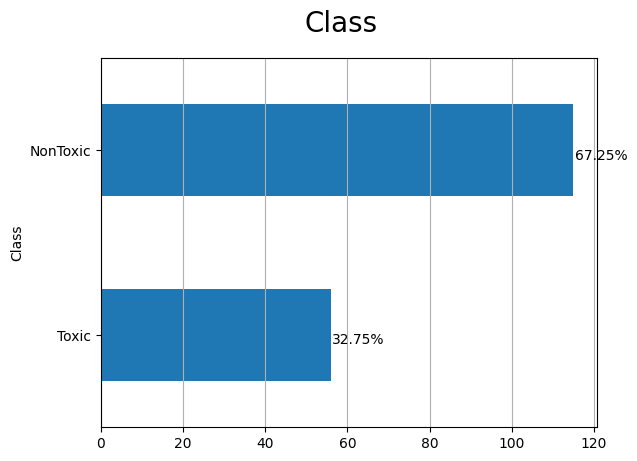

In [5]:
'''
Анализируем, какое количество нетоксичных и токсичных веществ (Class)
другими словами, мы группируем все объекты по их целевой переменной (Class) и просто считаем, сколько объектов попало в каждую группу
'''
y ="Class";   # Вот тут задаем название столбца, по значению в котором и будем группировать


'''
Далее считаем количество объектов с одинаковыми значениями в столбце y: toxicity[y].value_counts()
потом сортируем полученное sort_values()
и задаем plot
'''
Ox = toxicity[y].value_counts().sort_values().plot(kind="barh");


'''
Затем занимаемся тем, что формируем надписи для графике
'''
totals= [];
for i in Ox.patches:
    totals.append(i.get_width());
total = sum(totals);
for i in Ox.patches:
    Ox.text(i.get_width()+.3, i.get_y()+.20,
            str(round((i.get_width()/total)*100, 2))+'%',
            fontsize=10, color='black');
Ox.grid(axis="x");
plot.suptitle(y, fontsize=20);


'''
И наконец-то отрисовываем
'''
plot.show();

По графику видно, что нетоксичных элементов в два раза больше, чем нетоксичных.

<ipython-input-6-adb9d662cf83>:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=Ox[0]);   # Зададим данные для графика
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


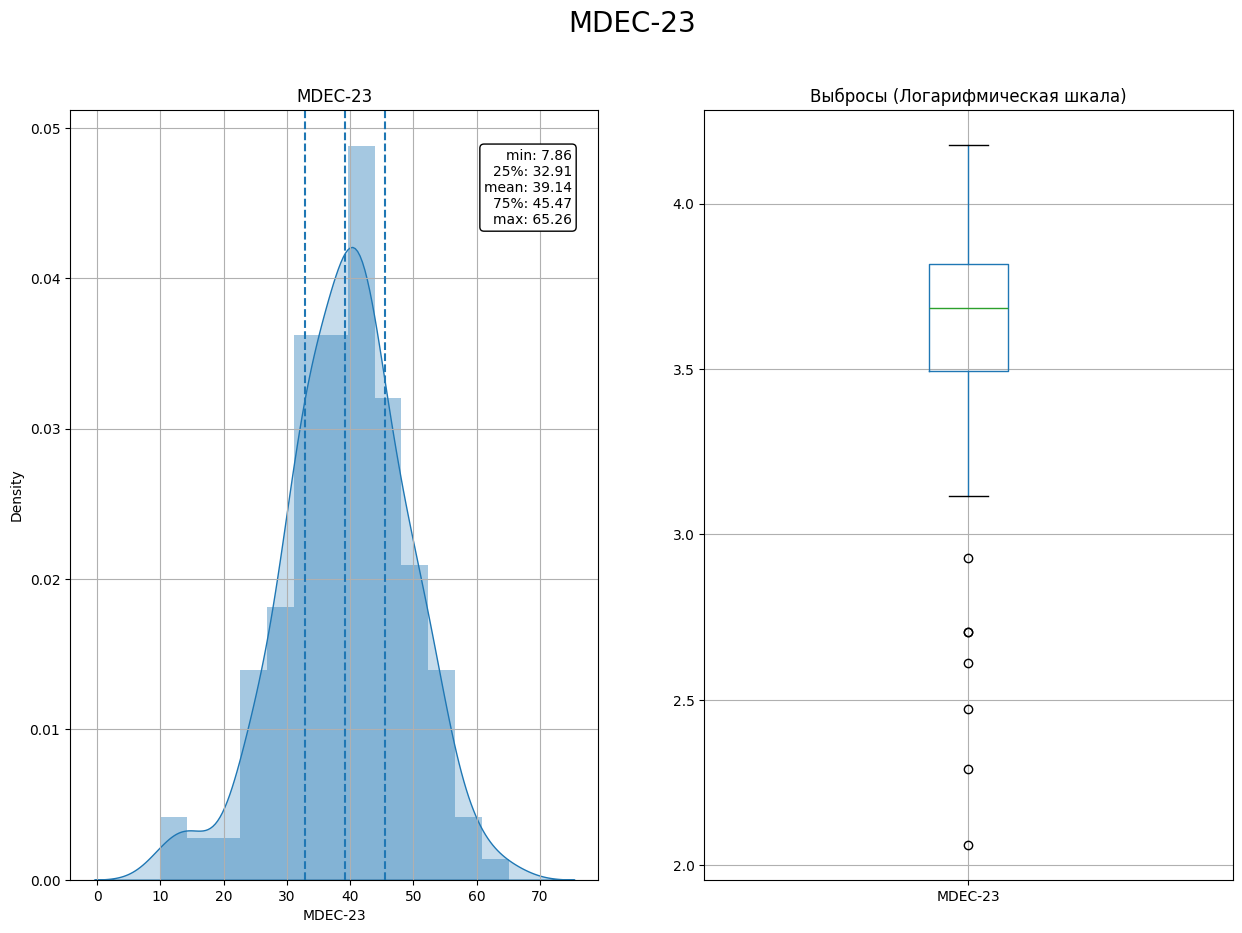

In [6]:
'''
Используем блочную диаграмму для графического отображения групп данных через их квартили.
Построим целевую пременную "MDEC-23"
'''
x = "MDEC-23";


'''
plot.subplots() - это функция, которая возвращает кортеж, содержащий фигуру и объект(ы) осей.
plot.subplots() возвращает кортеж с двумя элементами.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.
При использовании figure, Ox = plt.subplots()вы распаковываете этот кортеж в переменные figure и Ox.
Наличие figure полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью figure.savefig('yourfilename.png')).
'''
figure, Ox = plot.subplots(nrows=1, ncols=2,  sharex=False, sharey=False, figsize=(15, 10));
figure.suptitle(x, fontsize=20);   # Задаем заголовок основного рисунка


# Пропишем распределение:
Ox[0].title.set_text(x);   # Задаем название
variable = toxicity[x].fillna(toxicity[x].mean());   # Замена отсутствующих значений в датафрейме на средние
breaks = numpy.quantile(variable, q=numpy.linspace(0, 1, 11));   # Вычисляем q-й квантиль заданных данных вдоль указанной оси.
variable = variable[ (variable > breaks[0]) & (variable < breaks[10]) ];   # Собираем переменные с промежутка
seaborn.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=Ox[0]);   # Зададим данные для графика
destination = toxicity[x].describe();
Ox[0].axvline(destination["25%"], ls='--');
Ox[0].axvline(destination["mean"], ls='--');
Ox[0].axvline(destination["75%"], ls='--');
Ox[0].grid(True);
destination = round(destination, 2).apply(lambda x: str(x));
box = '\n'.join(("min: "+destination["min"], "25%: "+destination["25%"], "mean: "+destination["mean"], "75%: "+destination["75%"], "max: "+destination["max"]));
Ox[0].text(0.95, 0.95, box, transform=Ox[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1));


# Формируем надписи для графика boxplot
Ox[1].title.set_text('Выбросы (Логарифмическая шкала)');   # Устанавливаем заголовок
boxicity = pandas.DataFrame(toxicity[x]);
boxicity[x] = numpy.log(boxicity[x]);
boxicity.boxplot(column=x, ax=Ox[1]);


# Отрисовываем
plot.show();

Для показателя MDEC-23, имеющего нормальное распределение, разброс данных по графику "Ящик с усами" немаленький.

In [54]:
'''
А теперь обернем все, что было в предыдущей ячейке - в функцию show_dist для удобства повторного использования.
    :param x : Название столбца
    :param dataset : Датасет
'''
def show_destination(x, dataset):
    figure, Ox = plot.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(15, 10));
    figure.suptitle(x, fontsize=20);
    Ox[0].title.set_text(x);
    variable = dataset[x].fillna(dataset[x].mean());
    breaks = numpy.quantile(variable, q=numpy.linspace(0, 1, 11));
    variable = variable[(variable > breaks[0]) & (variable < breaks[10])];
    seaborn.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=Ox[0]);   # Запишем чтобы создать горизонтальную гистограмму
    destination = dataset[x].describe();

    # Добавим квантильные и средние линии
    Ox[0].axvline(destination["25%"], ls='--');
    Ox[0].axvline(destination["mean"], ls='--');
    Ox[0].axvline(destination["75%"], ls='--');
    Ox[0].grid(True);
    destination = round(destination, 2).apply(lambda x: str(x));
    box = '\n'.join(("min: " + destination["min"], "25%: " + destination["25%"], "mean: " + destination["mean"], "75%: " + destination["75%"], "max: " + destination["max"]));
    Ox[0].text(0.95, 0.95, box, transform=Ox[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))

    # Формируем надписи для графика
    Ox[1].title.set_text('Выбросы (Логарифмическая шкала)');   # Устанавливаем заголовок
    boxicity = pandas.DataFrame(dataset[x]);
    boxicity[x] = numpy.log(boxicity[x]);
    boxicity.boxplot(column=x, ax=Ox[1]);

    # Отрисовываем
    plot.show();


<ipython-input-54-d20792023ffe>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=Ox[0]);   # Запишем чтобы создать горизонтальную гистограмму
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*in

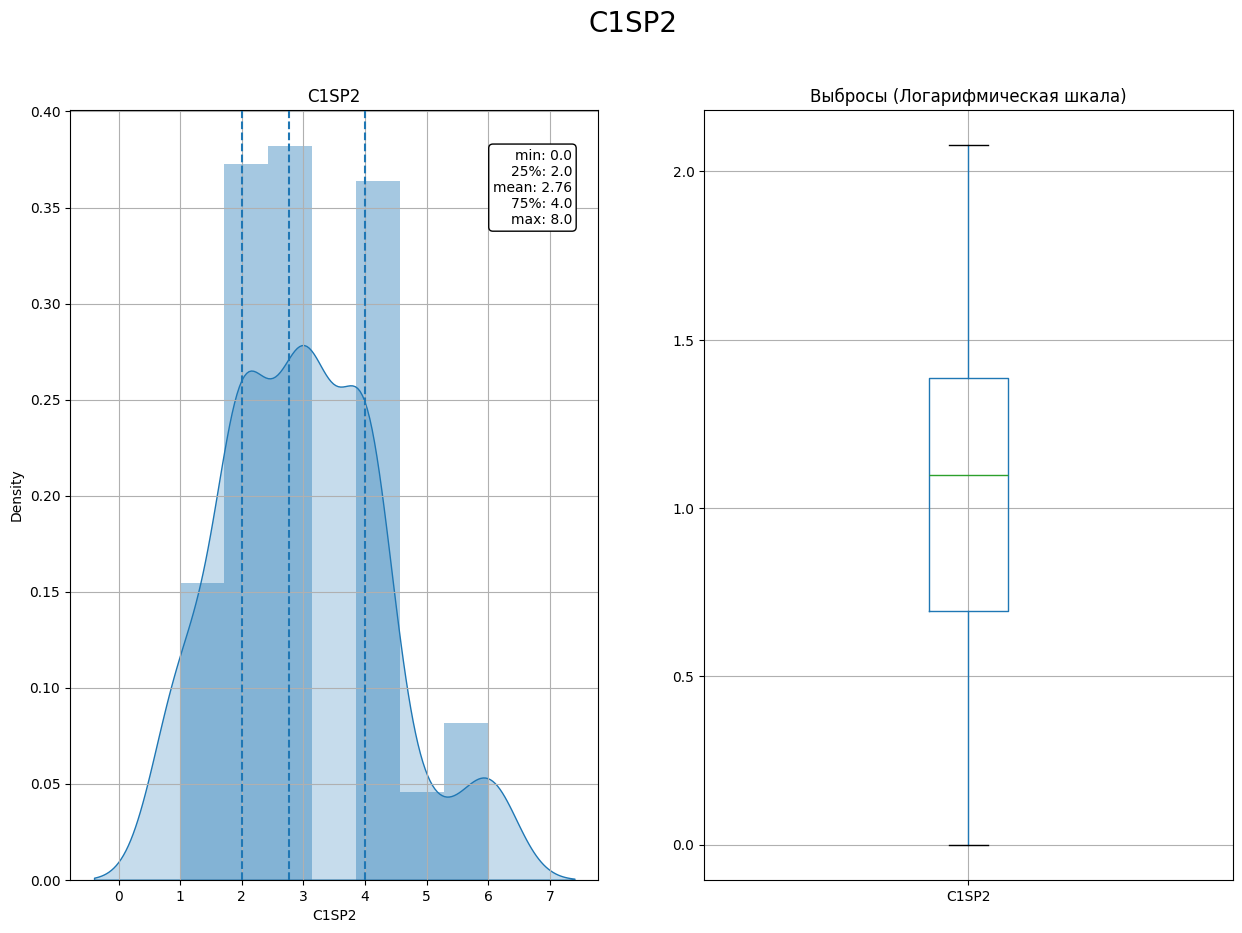

In [56]:
# Запуск функции для показателя MDEC-23
show_destination('C1SP2', toxicity);

На примере показателя C1SP2 с ± нормальным распределением, разброс данных минимальный.

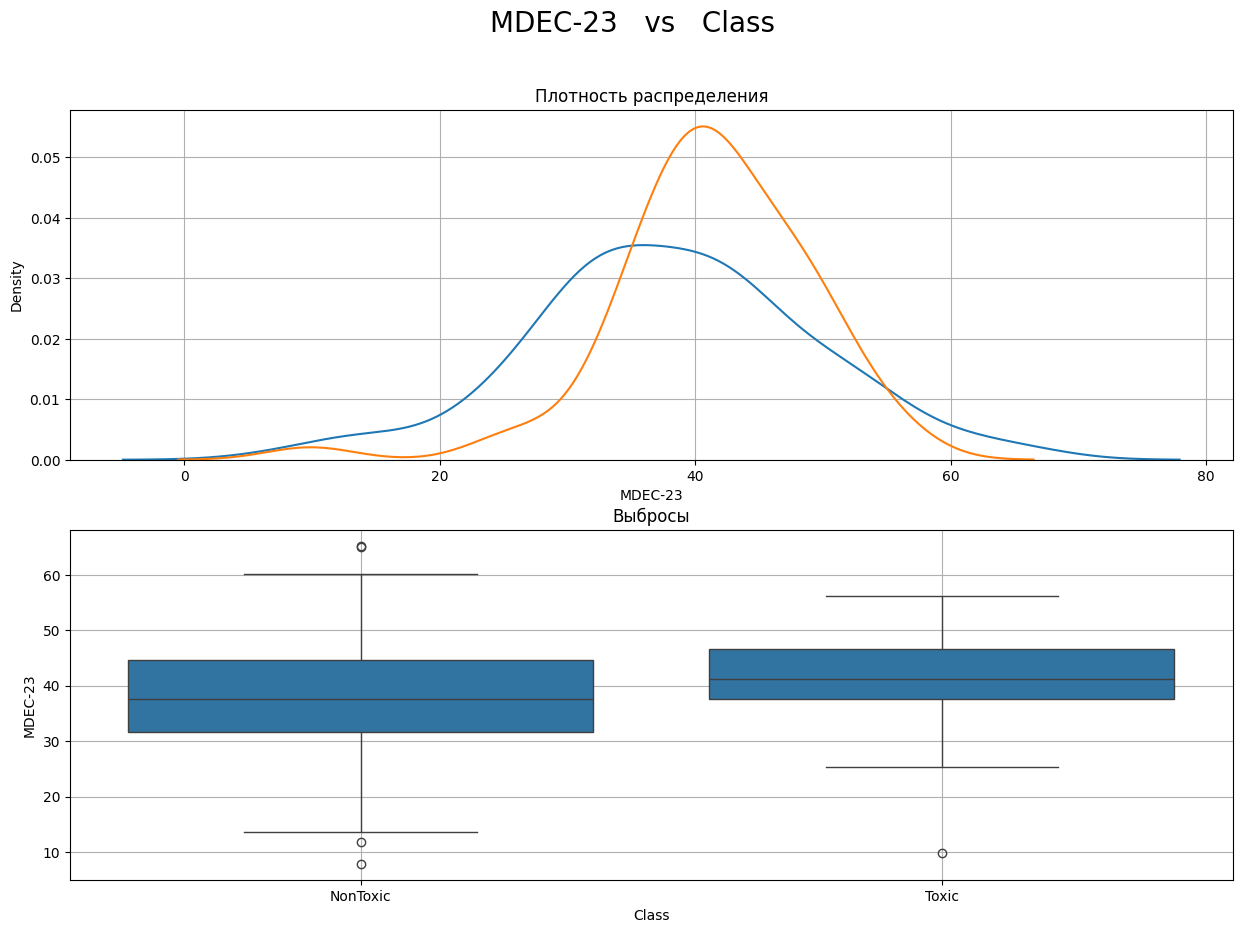

In [9]:
'''
Для того, чтобы понять, обладает ли "MDEC-23" предсказательной силой для класса токсичности "Class",
построим график плотности распределений и усиковую диаграмму MDEC-23 для каждого уникального Class.
Получаем объект рисунка и массив подграфиков, где
  первое число - количество строк,
  второе число - столбцов, sharex, sharey задают, нужно ли разделять ось между подграфиками
'''
categorical, numerical = "Class", "MDEC-23";
figure, Ox = plot.subplots(nrows=2, ncols=1,  sharex=False, sharey=False, figsize=(15, 10));   # Распаковываем кортеж в переменные figure и Ox
figure.suptitle(x + "   vs   " + y, fontsize=20);   # Получаем объект рисунка и массив подграфиков


'''
Пропишем распределение.
Построим график плотности распределения в столбце numerical, при условии, что значение в столбце toxicity[categorical] совпадет с i.
Перебирём все уникальные значения в столбце toxicity[categorical], categorical="Class" с проверкой условия.
'''
Ox[0].title.set_text('Плотность распределения');   # Назовём график
for i in toxicity[categorical].unique():
    seaborn.kdeplot(toxicity[toxicity[categorical]==i][numerical], label=i, ax=Ox[0]);   # Перебор уникальных значений с проверкой условия
Ox[0].grid(True);   # Настроим линии сетки
Ox[1].title.set_text('Выбросы');   # Назовём график
seaborn.boxplot(x=categorical, y=numerical, data=toxicity, ax=Ox[1]);   # Нарисуем блочную диаграмму, чтобы показать распределения по категориям
Ox[1].grid(True);   # Настроим линии сетки


plot.show();   # Отрисовываем


Из-за того, что нетоксичных элементов в два раза больше, то, следуя графикам, и вероятность разброса значений будет выше.

In [10]:
'''
Подготовим структуру словаря из фрейма данных со столбцами.
  axis - будут ли удалены строки или столбцы, содержащие пропущенные значения.
  how - удаляется ли строка или столбец из DataFrame, когда у нас есть хотя бы один NA или все NA.
  thresh - количество значений, не относящихся к NA.
  subse - Метки вдоль другой оси, которые следует учитывать, например, при отбраски строки, это будет список столбцов для включения.
  inplace - Нужно ли изменять DataFrame, не создавая новый.
'''
def preparing(dataset):
    dataset.loc[(dataset['MDEC-23'] < 30), 'mdec'] = 0;
    dataset.loc[(30 <= dataset['MDEC-23']) & (dataset['MDEC-23'] < 50), 'mdec'] = 1;
    dataset.loc[(dataset['MDEC-23'] >= 50), 'mdec'] = 2;
    dataset.loc[dataset['Class'] == 'NonToxic', 'toxiclass'] = 0;
    dataset.loc[dataset['Class'] == 'Toxic', 'toxiclass'] = 1;
    # dataset.drop('Unnamed: 0', axis=1, inplace=True);   # Удаление указанных меток из строк / столбцов
    noempty = dataset.dropna(axis=0, how='any', inplace=False);   # Удаление пропущенных значений
    return noempty;


In [11]:
'''
При разделении данных на обучающие и тестовые наборы вы должны следовать одному основному правилу:
  строки в обучающем наборе не должны также появляться в тестовом наборе.
Это потому, что модель видит целевые значения во время обучения и использует их для понимания явления.
Другими словами, модель уже знает правильный ответ для обучающих наблюдений (.
'''

# Разделение и властвование, 70% - тренировочная выборка, 30% - тестовая выборка
toxiraining, toxitesting = model_selection.train_test_split(toxicity, test_size=0.3);

# Подготавливаем данные в тренировачном и тестовом множествах одинаково
training = preparing(toxiraining);
testing = preparing(toxitesting);

# Вывод информации
print("Тренировочный x_shape:", training.drop("MDEC-23",axis=1).shape, "| Тестировочный x_shape:", testing.drop("MDEC-23",axis=1).shape);
print("Тренировочный y_mean:", round(numpy.mean(training["mdec"]),2), "| Тестировочный y_mean:", round(numpy.mean(testing["mdec"]),2));
print(training.drop("MDEC-23",axis=1).shape[1], "features:", training.drop("mdec",axis=1).columns.to_list());


Тренировочный x_shape: (119, 15) | Тестировочный x_shape: (52, 15)
Тренировочный y_mean: 1.05 | Тестировочный y_mean: 0.88
15 features: ['MDEC-23', 'MATS2v', 'ATSC8s', 'VE3_Dt', 'CrippenMR', 'SpMax7_Bhe', 'SpMin1_Bhs', 'C1SP2', 'GATS8e', 'GATS8s', 'SpMax5_Bhv', 'VE3_Dzi', 'VPC-4', 'Class', 'toxiclass']


Из-за несбалансированности датасета, класс токсичности у тренировочного и тестировочного множеств стремится к единице.

In [12]:
# Смотрим размер полученной выборки трейне
training.shape

(119, 16)

In [23]:
# Определяем все колонки тренировочного и тестировочного множеств
def aimless_columns():
  columns = training.columns.to_list();
  columns.remove('MDEC-23');
  columns.remove('Class');
  return columns;

# Формируем вспомогательный датасет (где все нужные фичи(столбцы), и нет целевой переменной) и MDEC-23 с целевой переменной.

# Для тренировочного множества
x_training = training[aimless_columns()];
y_training = training['mdec'];

# Для тестировочного множества
x_testing = testing[aimless_columns()];
y_testing = testing['mdec'];


In [14]:
# Нормируем значения
Y = 'mdec'
scaler = preprocessing.MinMaxScaler(feature_range=(0,1));   # Приведём Числовые переменные (Numeric Variable) к диапазону от 0 до 1
X = scaler.fit_transform(x_training);   # Преобразуем данные таким образом, что их распределение будет иметь среднее значение 0 и стандартное отклонение 1


'''
x_training - это весь экземпляр с атрибутами.
y_training - это метка каждого экземпляра.
'''
x_training_scaled = pandas.DataFrame(X, columns=x_training.columns,index=x_training.index);
y_training_scaled = y_training;

x_training_scaled.head()   # Выводим шапку, чтоб не мёрзнуть


,MATS2v,ATSC8s,VE3_Dt,CrippenMR,SpMax7_Bhe,SpMin1_Bhs,C1SP2,GATS8e,GATS8s,SpMax5_Bhv,VE3_Dzi,VPC-4,mdec,toxiclass
73,0.511654,0.515511,0.982027,0.769011,0.808890,0.431534,0.125,0.157075,0.182406,0.790812,0.965994,0.000000,0.5,0.0
118,0.340722,0.507547,0.966080,0.891965,0.862542,0.385812,0.500,0.260807,0.315652,0.814735,0.986078,0.608109,0.5,1.0
42,0.521481,0.559455,0.994406,0.800046,0.731082,0.784351,0.125,0.249957,0.238756,0.698140,0.999103,0.397759,0.5,0.0
58,0.075411,0.486568,0.981054,0.858000,0.878975,0.156257,0.375,0.125064,0.151863,0.850183,0.930395,0.405924,0.5,0.0
126,0.343464,0.575535,0.971259,0.931199,0.908142,0.377563,0.500,0.173106,0.131192,0.831346,0.988345,0.388075,0.5,1.0


<ipython-input-7-ce3f3598db63>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=Ox[0]);   # Запишем чтобы создать горизонтальную гистограмму
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


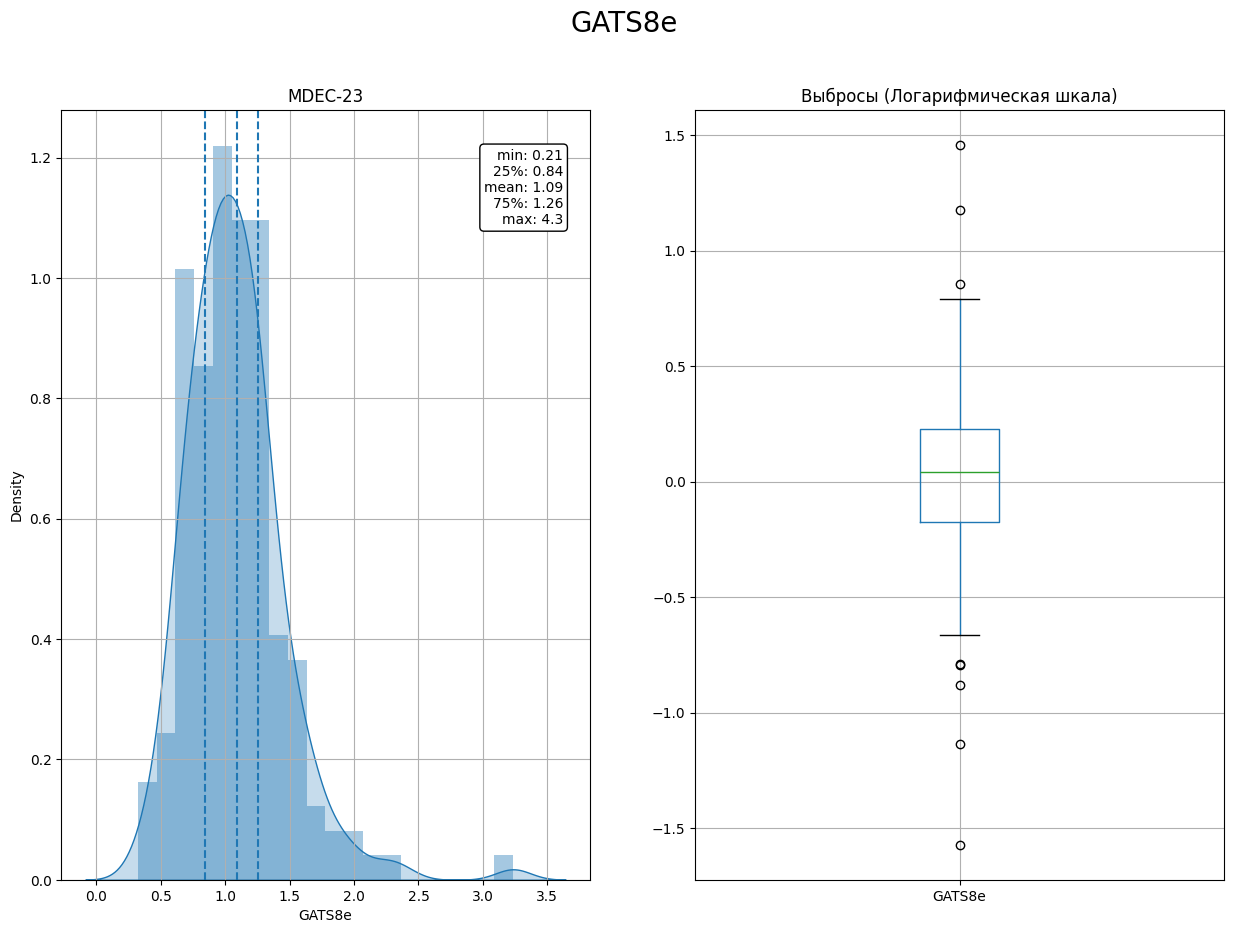

In [15]:
show_destination('GATS8e', toxicity);   # Используем ранее созданную нами функцию для отрисовки графиков

<ipython-input-7-ce3f3598db63>:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=Ox[0]);   # Запишем чтобы создать горизонтальную гистограмму
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


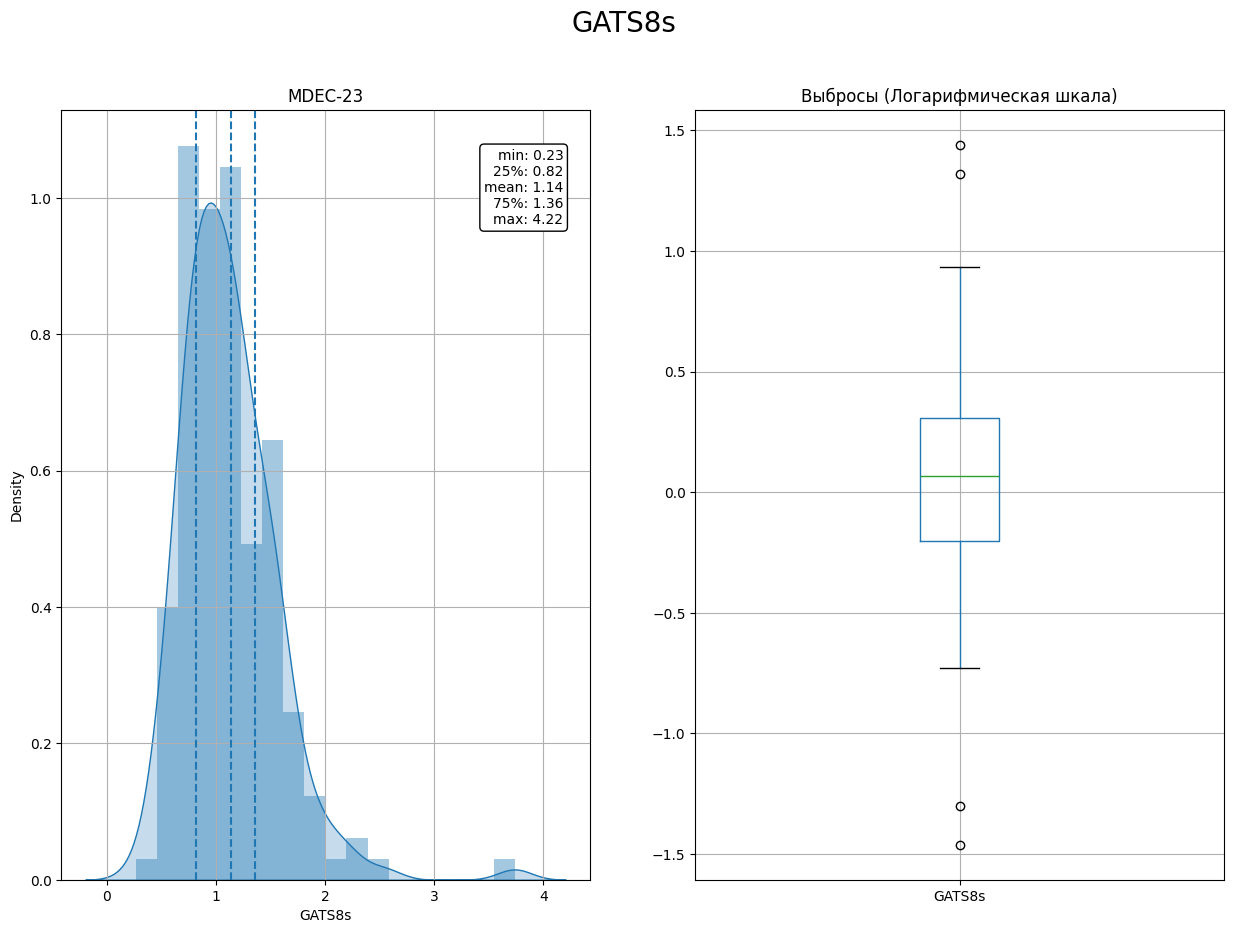

In [16]:
show_destination('GATS8s', toxicity);   # Используем ранее созданную нами функцию для отрисовки графиков

Два максимально зависимых друг от друга показателя GATS8e и GATS8s (ниже будет корреляция, и в прошлых лабораторных была) имеют аналогичные распределения и разбросы значений.

In [17]:
# Смотрим, что лежит в X, который результат нормировки x_training
X

array([[0.51165448, 0.51551105, 0.98202742, ..., 0.        , 0.5       ,
        0.        ],
       [0.34072212, 0.50754695, 0.9660796 , ..., 0.60810942, 0.5       ,
        1.        ],
       [0.5214808 , 0.55945496, 0.99440617, ..., 0.39775924, 0.5       ,
        0.        ],
       ...,
       [0.42870201, 0.47630415, 0.22822419, ..., 0.44242895, 0.5       ,
        1.        ],
       [0.25662706, 0.73834012, 0.98428967, ..., 0.24696867, 0.5       ,
        0.        ],
       [0.1583638 , 0.55166724, 0.97000248, ..., 0.        , 0.5       ,
        0.        ]])

Нормированные (от 0 до 1) данные по показателям датасета, кроме целевого показателя и класса, показывают, в каком диапазоне они находятся.

In [18]:
# Смотрим какие индексы (по сути, номера объектов в основном датасете) остались в тренировочном множестве
x_training.index


Index([ 73, 118,  42,  58, 126,  88, 158,  90,  20, 167,
       ...
       105,  87, 153,  69,  92,  28,   1,  97, 142,   8],
      dtype='int64', length=119)

"Новый порядок" данных после перемешки датасета.

In [19]:
'''
Метод fit(data) используется для вычисления среднего значения и стандартного отклонения для данной функции, которые будут использоваться в дальнейшем для масштабирования.
Метод transform(data) используется для выполнения масштабирования с использованием среднего значения и стандартного отклонения, рассчитанного с использованием метода .fit().
Метод fit_transform() выполняет как подгонку, так и преобразование.
 x_training - это весь экземпляр с атрибутами,
 y_training - это метка каждого экземпляра.
x_training_scaled - фрейм данных с именами объектов,
x_testing_scaled.values - значения, без имен объектов
 '''
X = scaler.fit_transform(x_testing);
x_testing_scaled = pandas.DataFrame(X, columns=x_testing.columns,index=x_testing.index);
y_testing_scaled = y_testing;


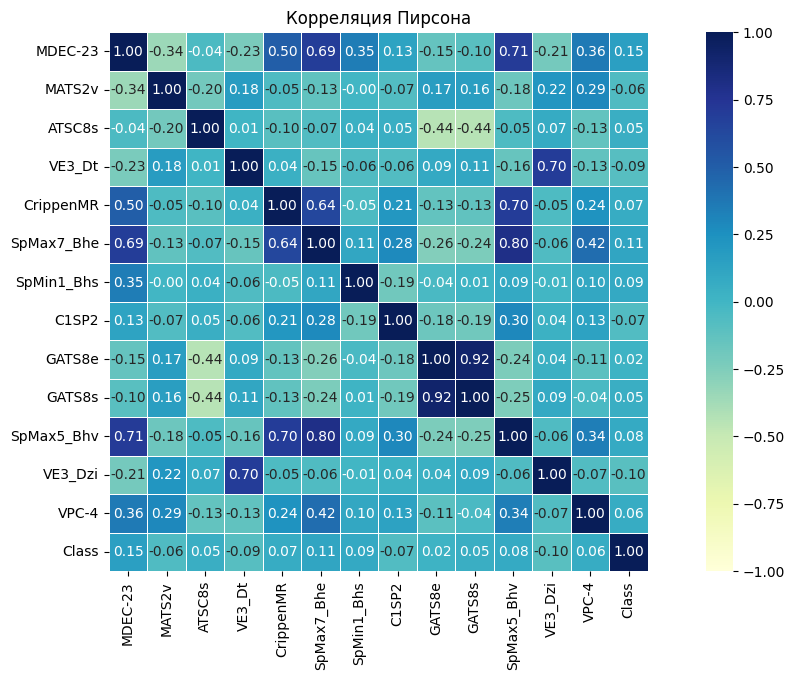

In [20]:
'''
Выбор параметров (фич, features) — это процесс выбора для обучения модели подмножества параметров из всех параметров датасета.
Это упрощает обучение модели и уменьшает вероятность переобучения (когда модель слишком сильно адаптируется к обучающим данным и плохо работает вне их набора).
Вычислим матрицу корреляции, чтобы увидеть, какие параметры коррелируют друг с другом и целевой переменной:
'''
correlation_matrix = toxicity.copy();
plot.figure(figsize=(15,7), dpi=100);


'''
correlation_matrix принимает входное отношение с числовыми столбцами и вычисляет коэффициент корреляции Пирсона между
каждой парой входных столбцов и возвращает матрицу корреляции в формате триплета.

То есть каждая парная корреляция идентифицируется тремя возвращаемыми столбцами:
имя первой переменной, имя второй переменной и значение корреляции пары.

Функция также возвращает два дополнительных столбца: number_of_ignored_input_rows и number_of_processed_input_rows.
Значение четвертого/пятого столбца указывает количество строк из ввода, которые игнорируются/используются для вычисления соответствующего значения корреляции.
Любая входная пара с NULL, Inf или NaN игнорируется.
Корреляционная матрица симметрична со значением 1 на всех диагональных элементах.
'''
for column in correlation_matrix.columns: #зададим условия для столбцов
  if correlation_matrix[column].dtype == "O":
    correlation_matrix[column] = correlation_matrix[column].factorize(sort=True)[0];
correlation_matrix = correlation_matrix.corr(method="pearson",numeric_only = True);


'''
Основная цель Seaborn Heatmap — визуализировать correlation matrix  для feature selection для решения задач.
Vmin и vmax устанавливают нижнюю и верхнюю границы цветовой полосы.

Чтобы изменить цвет heatmap, используют параметр cmap (colormap) в seaborn.heatmap.

Каждая ячейка seaborn.heatmap отображается по номеру, и если нужно показать этот номер в ячейке,
тогда используется seaborn.heatmap() annotation.

Если записать "True" в annot, это значение будет отображаться в каждой ячейке.
fmt позволяет добавлять строковые (текстовые) значения в ячейку.
Cbar по умолчанию имеет логическое значение True, если поменять его намFalse, то цветная полоса скрывается.
'''
seaborn.heatmap(correlation_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5, square=True);
plot.title("Корреляция Пирсона");


Как было указано выше, наиболее зависимые показатели - это GATS8e и GATS8s. Некоторые остальные показатели (SpMax7 + SpMax5_Bhv = 0.8, например) также сильно зависят друг от друга.

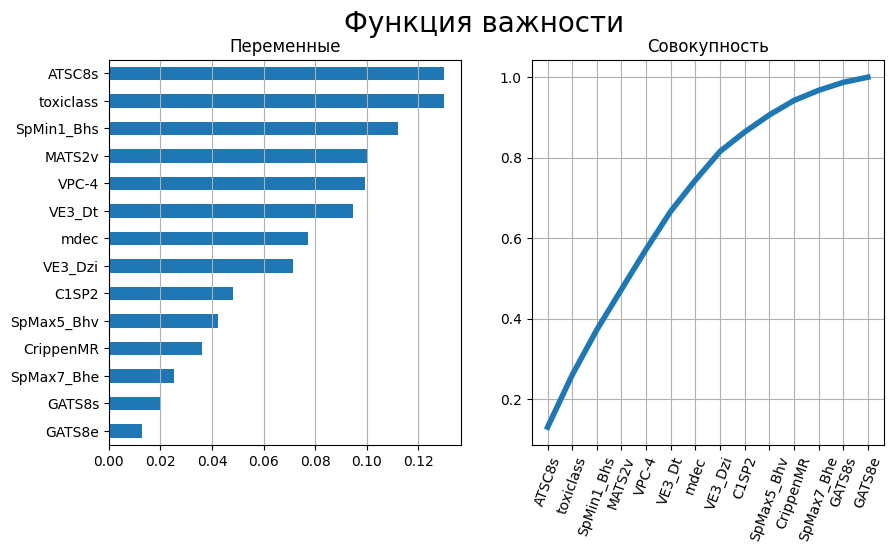

In [21]:
'''
Оцениваем важность каждой фичи c помощью RandomForestClassifier
'''
x = x_training_scaled.values.round(0);
y = x_training_scaled.values.round(0);
feature_names = x_training_scaled.columns.tolist();   # Имена столбцов в data.
model = ensemble.RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0);
model.fit(x,y);
# Оценка, присваиваемая функциям модели машинного обучения,которая определяет, насколько «важной» является функция для прогноза модели:
importances = model.feature_importances_;
toxicity_importances = pandas.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False);
toxicity_importances['cumsum'] = toxicity_importances['IMPORTANCE'].cumsum(axis=0);
toxicity_importances = toxicity_importances.set_index("VARIABLE");



'''
Формируем надписи для графика
  ticks : подобный массиву, содержащий список местоположений xtick. Передача пустого списка удаляет все xticks. (По желанию)
  labels : подобный массиву, содержащий метки для размещения в заданных местах тиков. Этот аргумент может быть передан только в том случае, если также переданы тики. (По желанию)
  kwargs : текстовые свойства, которые можно использовать для управления внешним видом меток.
Функция Matplotlib xticks() возвращает:
locs: список местоположений xtick.
labels: список текстовых объектов xlabel
plot.grid - Настройка линий сетки.
axis - Ось, к которой применяются изменения.
'''
figure, Ox = plot.subplots(nrows=1, ncols=2, sharex=False, sharey=False,figsize=(10,5),dpi=100);   # Распаковываем  кортеж в переменные figure и Ox.
figure.suptitle("Функция важности", fontsize=20);
Ox[0].title.set_text('Переменные');   # Подпишем график
toxicity_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=Ox[0]).grid(axis="x");
Ox[0].set(ylabel="");
Ox[1].title.set_text('Совокупность');   # Подпишем график
toxicity_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=Ox[1]);
Ox[1].set(xlabel="", xticks=numpy.arange(len(toxicity_importances)), xticklabels=toxicity_importances.index);
plot.xticks(rotation=70);
plot.grid(axis='both');   # Настроим линии сетки.

# Отрисовываем
plot.show();

Целевой класс находится практически на одной строчке с показателем ATSC8s, когда как выбранная целевая переменная занимает ровно среднюю важность (7-ая позиция из 13-ти возможных).

In [25]:
'''
Проектирование, обучение, тестирование и оценка модели машинного обучения:
'''
aimless_columns = aimless_columns();
aimless_columns.remove('C1SP2');

x_train = x_training_scaled[aimless_columns];
y_train = y_training_scaled;

x_test = x_testing_scaled[aimless_columns];
y_test = y_testing_scaled;

In [26]:
'''
Будем использовать GradientBoostingClassifier - градиентный бустинг.
Он строит предсказание в виде ансамбля слабых предсказывающих моделей, которыми в основном являются деревья решений.
Из нескольких слабых моделей в итоге мы собираем одну, но уже эффективную.
Общая идея алгоритма – последовательное применение предиктора (предсказателя) таким образом,
что каждая последующая модель сводит ошибку предыдущей к минимуму.
Оценивать качество предсказаний будем по RandomizedSearchCV.
'''
model = ensemble.GradientBoostingClassifier();   # Вызов модели
# Определение киберпараметров
param_dic = {'learning_rate':[0.15,0.1,0.05],   # Весовой коэффициент для поправок по новым деревьям при добавлении в модель
             'n_estimators':[100,250,500],   # Количество деревьев, добавленных в модель
             'max_depth':[2,3,4,5],   # Максимальная глубина дерева
             'min_samples_split':[2,4,6],   # Задает минимальное количество выборок для разделения
             'min_samples_leaf':[1,3,5],   # Минимальное количество выборок для формирования листа
             'max_features':[2,3,4],   # Квадратный корень из функций обычно является хорошей отправной точкой
             'subsample':[0.7,0.8,0.9,1]};   # Образцы, которые будут использоваться для подгонки индивидуального базового файла
# Рандомизированный поиск по гиперпараметрам
random_search = model_selection.RandomizedSearchCV(model, param_distributions=param_dic, n_iter=10, scoring="accuracy").fit(x_train, y_train);
print('Лучшие параметры модели:', random_search.best_params_);
print('Лучшая средняя точность модели:', random_search.best_score_);
model = random_search.best_estimator_;   # Здесь теперь хранятся параметры, при которых были получены наилучшие метрики на тренировочном множестве

Лучшие параметры модели: {'subsample': 0.7, 'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 3, 'learning_rate': 0.15}
Лучшая средняя точность модели: 1.0


In [28]:
'''
x_train - это тренировочный датасет;
y_train - это целевая переменная для каждого объекта в x_train.
'''
model.fit(x_train, y_train);   # Заполняем модель данным из трайн датасетов
test_predicting = model.predict_proba(x_test); # Прогнозирование на тестировочном множестве


'''
Функция Predict() принимает только один аргумент , который представляет собой тестировочный датасет.
'''
predicting = model.predict(x_test).astype('int32');

In [29]:
# Для каждого объекта получаем вектор вероятностей отнесения этого объекта к классам Class
test_predicting

array([[9.99999971e-01, 2.86401951e-08, 1.93736103e-10],
       [1.33293968e-09, 9.99999993e-01, 5.90856902e-09],
       [5.00886773e-08, 9.99999909e-01, 4.04980356e-08],
       [2.31311185e-07, 9.99999753e-01, 1.52842389e-08],
       [9.99954157e-01, 4.58129174e-05, 2.96317630e-08],
       [9.99999685e-01, 3.09217279e-07, 5.90137423e-09],
       [1.34828878e-07, 9.99999858e-01, 7.21576588e-09],
       [1.09358709e-06, 9.99997582e-01, 1.32474036e-06],
       [9.99999994e-01, 5.42145129e-09, 9.89367912e-11],
       [1.83262347e-08, 9.99999939e-01, 4.24734634e-08],
       [9.32486885e-08, 9.99999904e-01, 3.10039703e-09],
       [2.27080501e-08, 9.99999913e-01, 6.47038994e-08],
       [9.99999468e-01, 5.31219248e-07, 9.74378774e-10],
       [9.33552408e-08, 9.99999877e-01, 3.01433807e-08],
       [5.57792866e-07, 9.99999301e-01, 1.41314045e-07],
       [3.25295538e-11, 1.07919003e-08, 9.99999989e-01],
       [8.29530865e-08, 9.99999771e-01, 1.45696431e-07],
       [5.06656015e-08, 9.99999

Характеризует соотнесение вероятностей принадлежности показателя к целевому классу.

In [30]:
# Истинное значение, какие параметры к какому классу токсичности относятся
y_test.astype('int32')   # astype позволяет преобразовывать тип данных существующего столбца данных в набор данных

,mdec
144,0
127,1
94,1
122,1
150,0
132,0
152,1
123,1
166,0
96,1


Показывает истинную принадлежность к целевому классу.

In [31]:
# Accuray e AUC
'''
Теперь смотрим метрики на тестовом датасете
'''
accuracy = metrics.accuracy_score(y_test, predicting);   # Оценим точность классификации
auc = metrics.roc_auc_score(y_test, test_predicting,  multi_class='ovo', average= "weighted");   # Возвращаем долю правильно классифицированных выборок
print("Точность (общее количество правильных предсказаний): ",  round(accuracy, 2));
print("Общая производительность модели (Area Under Curve): ", round(auc, 2));


## Precision e Recall
'''
Получим результат
'''
recall = metrics.recall_score(y_test, predicting, average="weighted");
precision = metrics.precision_score(y_test, predicting, average="weighted");
print("Воспоминание (все единички верны):", round(recall, 2));
print("Точность (уверенность при прогнозировании 1): ", round(precision, 2));
print("Детали: ");
print(metrics.classification_report(y_test, predicting, target_names=[str(i) for i in numpy.unique(y_test)]));

Точность (общее количество правильных предсказаний):  1.0
Общая производительность модели (Area Under Curve):  1.0
Воспоминание (все единички верны): 1.0
Точность (уверенность при прогнозировании 1):  1.0
Детали: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00        34
         2.0       1.00      1.00      1.00         6

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



Вероятность уверенности в значениях везде равна единице...

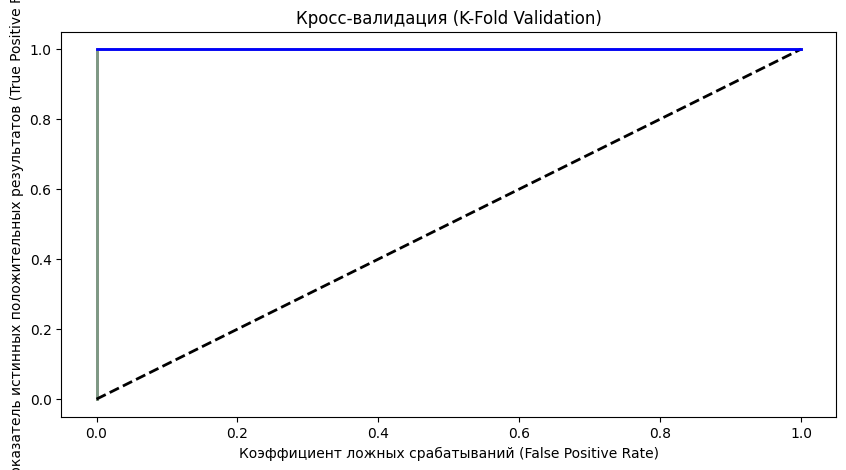

In [57]:
'''
Строим ROC кривые
'''
stratified = model_selection.StratifiedKFold(n_splits=10, shuffle=True);
tprs, aucs = [], [];   # Temperature Programmed Reaction Spectroscopy, Area Under Curve
mean_fpr = numpy.linspace(0,1,100);   # False Positive Rate
figure = plot.figure(figsize=(10,5), dpi=100);


'''
iloc - позволяет получить определенное значение, принадлежащее к строке и столбцу, используя указанные значения индекса
x_train - это весь экземпляр с атрибутами
y_train - это метка каждого экземпляра
random_subsets - разделяет массивы / матрицы на случайные тестовые подмножества
'''
i = 1
for training, testing in stratified.split(x_train, y_train):
    x_training_selected = x_train.iloc[training];
    y_training_selected = y_train.iloc[training];
    x_random_subsets = x_train.iloc[testing];
    y_random_subsets = y_train.iloc[testing];

    prediction = model.fit(x_training_selected, y_training_selected).predict_proba(x_random_subsets);
    fpr, tpr, t = metrics.roc_curve(y_random_subsets, prediction[:, 1], pos_label=1);
    tprs.append(numpy.interp(mean_fpr, fpr, tpr));
    roc_auc = metrics.auc(fpr, tpr);
    aucs.append(roc_auc);
    plot.plot(fpr, tpr, lw=2, alpha=0.3, label='Сложение операционной характеристики (ROC) %d (Площадь под кривой ошибок AUC = %0.2f)' % (i, roc_auc));
    i = i + 1;


'''
Получим результат
'''
plot.plot([0,1], [0,1], linestyle='--', lw=2, color='black');
mean_tpr = numpy.mean(tprs, axis=0);
mean_auc = metrics.auc(mean_fpr, mean_tpr);


'''
Построим график
'''
plot.plot(mean_fpr, mean_tpr, color='blue', label=r'Mean ROC (AUC = %0.2f )' % (mean_auc), lw=2, alpha=1);
plot.xlabel('Коэффициент ложных срабатываний (False Positive Rate)');
plot.ylabel('Показатель истинных положительных результатов (True Positive Rate)');
plot.title('Кросс-валидация (K-Fold Validation)');
# plot.legend(loc="lower right");
plot.show();

График демонстрируют точность предсказываемых значений в зависимости от выбранного порога.

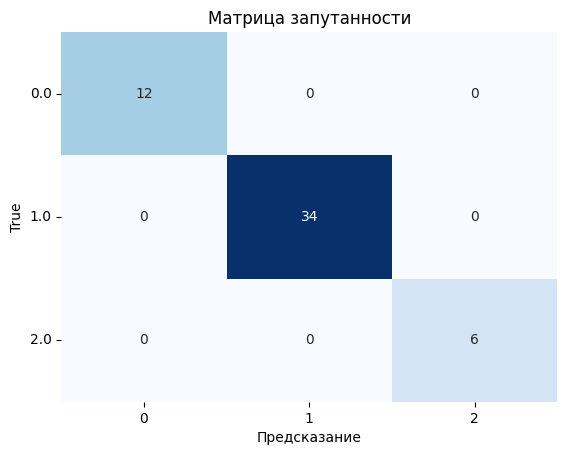

In [34]:
'''
Матрица запутанности (Мультиклассовая)
'''
classes = numpy.unique(y_test);
figure, Ox = plot.subplots();
confusion_matrix = metrics.confusion_matrix(y_test, predicting, labels=classes);
seaborn.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plot.cm.Blues, cbar=False);
Ox.set(xlabel='Предсказание', ylabel='True', title='Матрица запутанности');
Ox.set_yticklabels(labels=classes, rotation=0);

plot.show();   # Построим график

В основном, данные предсказывались с большой погрешностью во время второго деления (34 ошибочных значения из 171-го). В остальных случаях показатель запутанности был достаточно хорошим (12 и 6 ошибочных значений из 171-го)

In [36]:
'''
Вспомогательная функция для построения матрицы запутанности для каждого класса
'''
def compute_class(ls_res, class_value):   # Возвращаем строку имен классов
    y_t_class = ls_res.copy().astype(int);
    y_t_class = y_t_class.apply(lambda c: 1 if c == class_value else 0);
    return y_t_class;

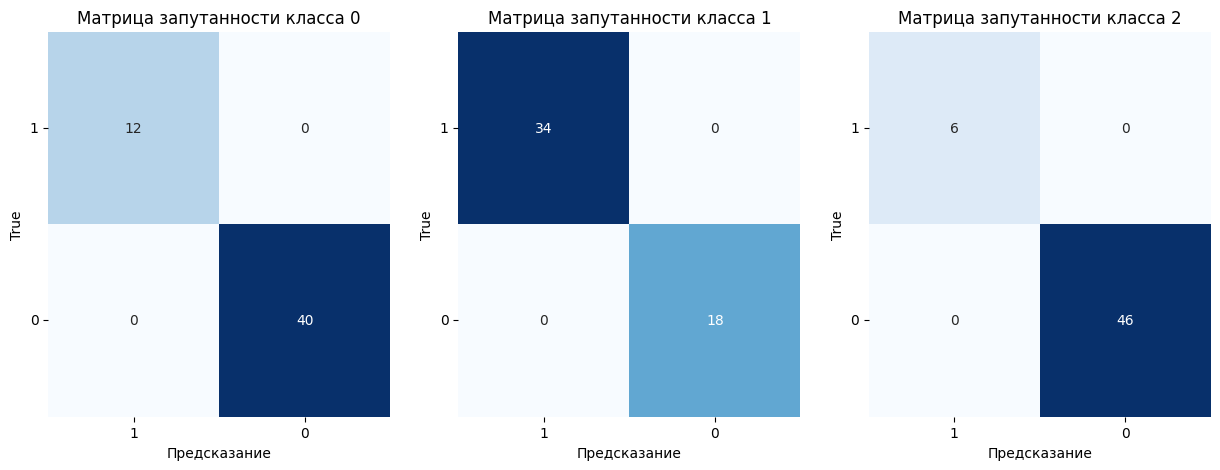

In [51]:
'''
Матрица запутанности (для каждого класса по отдельности)
'''
classes = numpy.unique(y_test).astype(int);
lbs = [1,0];


'''
plot.subplots() - это функция, которая возвращает кортеж (с двумя элементами), содержащий фигуру и объект(ы) осей.
1-й должен быть объектом фигуры, а 2й должен быть группой объектов второстепенных сюжетов.
При использовании figure, Ox = plot.subplots() вы распаковываете этот кортеж в переменные figure и Ox.

Наличие figure полезно, если вы хотите изменить атрибуты уровня фигуры или сохранить фигуру как файл изображения позже
(например, с помощью figure.savefig('yourfilename.png')).
plot.grid - Настройка линий сетки.
'''
figure, Ox = plot.subplots(nrows=1, ncols=3, figsize=(15,5), dpi=100);
for i_class in classes:
    y_one_class = compute_class(y_test, i_class);
    predicted_one_class = compute_class(pandas.Series(predicting.tolist()), i_class);   # Возвращает строку имен классов
    confusion_matrix = metrics.confusion_matrix(y_one_class, predicted_one_class, labels=lbs);
    seaborn.heatmap(confusion_matrix, annot=True, fmt='d', cmap=plot.cm.Blues, cbar=False, ax=Ox[i_class]);
    Ox[i_class].set(xlabel='Предсказание', ylabel='True', title=f"Матрица запутанности класса {i_class}");
    Ox[i_class].set_xticklabels(labels=lbs, rotation=0);
    Ox[i_class].set_yticklabels(labels=lbs, rotation=0);


plot.show();   # Построим график

Для трёх классов есть примерно равная вероятность получить запутанность в примерно 41-ом случае из 171-го. Это достаточно плохой показатель.

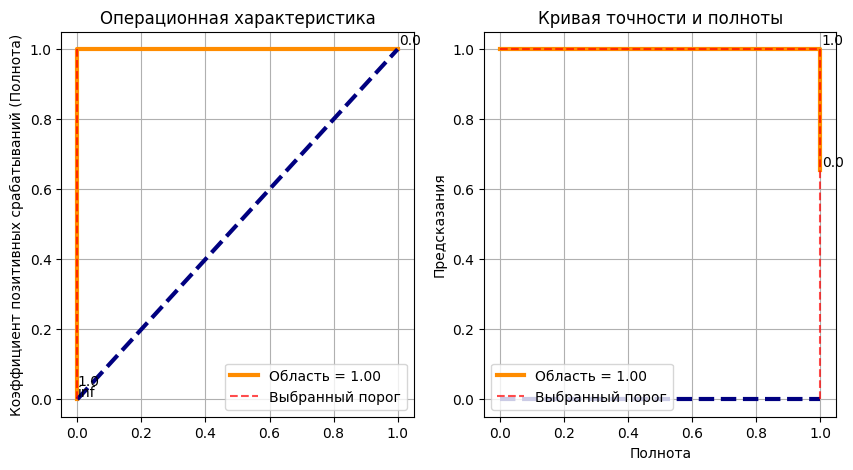

In [50]:
'''
Еще ROC-кривые
'''
classes = numpy.unique(y_test);
figure, Ox = plot.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=100);


# Построим кривую ROC
# Ложные срабатывания, истинные срабатывания, пороговые значения
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_predicting[:, 1], pos_label=1);
roc_auc = metrics.auc(fpr, tpr);
Ox[0].plot(fpr, tpr, color='darkorange', lw=3, label='Область = %0.2f' % roc_auc);
Ox[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--');
Ox[0].hlines(y=recall, xmin=0, xmax=1-confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1]), color='red', linestyle='--', alpha=0.7, label='Выбранный порог');
Ox[0].vlines(x=1-confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1]), ymin=0, ymax=recall, color='red', linestyle='--', alpha=0.7);
Ox[0].set(xlabel='', ylabel='Коэффициент позитивных срабатываний (Полнота)', title='Операционная характеристика');
Ox[0].legend(loc='lower right');
Ox[0].grid(True);


'''
Найдем пороговые значения ROC
'''
plot_thresholds = []
for i,t in enumerate(thresholds):
    t = numpy.round(t,1);
    if t not in plot_thresholds:
        Ox[0].annotate(t, xy=(fpr[i],tpr[i]), xytext=(fpr[i], tpr[i]), textcoords='offset points', ha='left', va='bottom');
        plot_thresholds.append(t);
    else:
        next;


'''
Построим привую P-R
Компромисс между точностью и полнотой для различных пороговых значений
'''
precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, test_predicting[:,1], pos_label=1);
roc_auc = metrics.auc(recalls, precisions);
Ox[1].plot(recalls, precisions, color='darkorange', lw=3, label='Область = %0.2f' % roc_auc);
Ox[1].plot([0,1], [(confusion_matrix[1,0]+confusion_matrix[1,0])/len(y_test), (confusion_matrix[1,0]+confusion_matrix[1,0])/len(y_test)], linestyle='--', color='navy', lw=3);
Ox[1].hlines(y=precision, xmin=0, xmax=recall, color='red', linestyle='--', alpha=0.7, label='Выбранный порог');
Ox[1].vlines(x=recall, ymin=0, ymax=precision, color='red', linestyle='--', alpha=0.7);
Ox[1].set(xlabel='Полнота', ylabel='Предсказания', title='Кривая точности и полноты');
Ox[1].legend(loc='lower left');
Ox[1].grid(True);


'''
Пороговые значения P-R
'''
plot_thresholds = []
for i,t in enumerate(thresholds):
    t = numpy.round(t,1)
    if t not in plot_thresholds:
        Ox[1].annotate(numpy.round(t,1), xy=(recalls[i],precisions[i]), xytext=(recalls[i],precisions[i]), textcoords='offset points', ha='left', va='bottom');
        plot_thresholds.append(t);
    else:
        next;


'''
Построение графиков
'''
plot.show();

Графики демонстрируют точность предсказываемых значений в зависимости от выбранного порога.

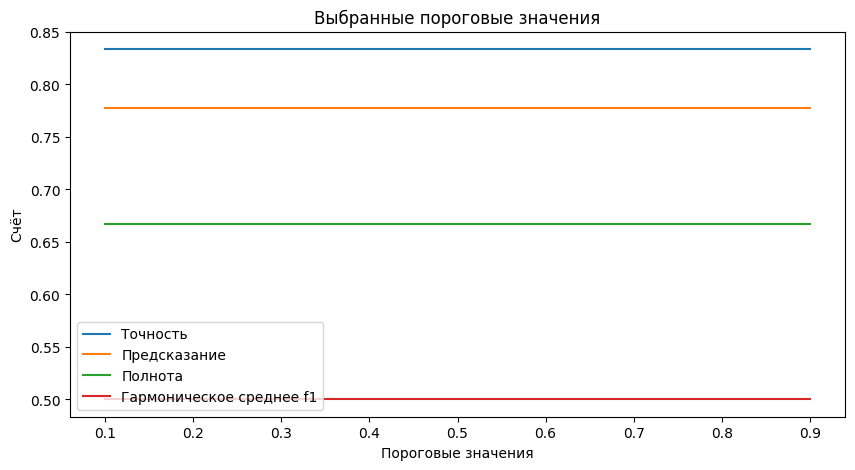

In [52]:
'''
Подсчёт баллов для различных пороговых значений.
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("Значение отсечки", "Значение метрики") для каждой метрики accuracy, precision, recall, f1.
'''
figure, Ox = plot.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100);
dic_scores = {'Точность':[], 'Предсказание':[], 'Полнота':[], 'Гармоническое среднее f1':[]};
x_training, x_testing, y_training, y_testing = model_selection.train_test_split(x_train, y_train, test_size=0.2);
test_predicting = model.fit(x_training, y_training).predict_proba(x_testing)[:,1];
thresholds = [];
for threshold in numpy.arange(0.1, 1, step=0.1):
    predicted = (test_predicting > threshold);
    thresholds.append(threshold);
    dic_scores['Точность'].append(metrics.accuracy_score(y_testing, predicted));
    dic_scores['Предсказание'].append(metrics.precision_score(y_testing, predicted, average='macro', zero_division=1));
    dic_scores['Полнота'].append(metrics.recall_score(y_testing, predicted, average='macro'));
    dic_scores['Гармоническое среднее f1'].append(metrics.f1_score(y_testing, predicted, average='macro'));


'''
Добавим отображение линий
'''
dtf_scores = pandas.DataFrame(dic_scores).set_index(pandas.Index(thresholds));
Ox.set(xlabel='Пороговые значения', ylabel='Счёт', title='Выбранные пороговые значения');
dtf_scores.plot(ax=Ox);


'''
Построение графика
'''
plot.show();

По графику можно смело утверждать, что на любом наборе данных можно встретить одиннаковые показатели точности, предсказания, полноты и гармонического среднего f1.